<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/HairTextureClassification/blob/main/SLP_HairTexture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


# Enviroment

In [ ]:
!rm -rf ./HairTextureClassification
!git clone https://github.com/CarmenTheodoraCraciun/HairTextureClassification.git

Cloning into 'HairTextureClassification'...
remote: Enumerating objects: 30854, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 30854 (delta 11), reused 5 (delta 5), pack-reused 30835 (from 4)
Receiving objects: 100% (30854/30854), 824.32 MiB | 35.41 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Updating files: 100% (16606/16606), done.


In [ ]:
import os
import cv2
import shutil
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, SGD
from imblearn.over_sampling import SMOTE
from keras import Input
from numba import cuda
from collections import Counter
from collections import defaultdict
import collections
from math import gcd
from functools import reduce
from google.colab import files
from IPython import get_ipython
from IPython.display import display

##Optimizing the training environment

* Enabling mixed precision for optimal performance on the GPU

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

##Cleaning up the TensorFlow session

* to avoid memory issues

In [ ]:
tf.keras.backend.clear_session()
collected = gc.collect()
print(f"Garbage collector freed {collected} unreachable objects.")

Garbage collector freed 0 unreachable objects.


#Loading data (unbalanced)

In [ ]:
def load_images_and_labels(input_dir, size=(96, 96)):
    images = []
    labels = []
    invalid_images = []

    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
                    images.append(img)
                    labels.append(category)

                    if img.shape[:2] != (96, 96):
                        invalid_images.append((img_name, img.shape[:2]))

    if invalid_images:
        print("Warning: Some images are not 96x96!")
        for img_name, shape in invalid_images:
            print(f" {img_name} has size {shape}")

    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_images_and_labels('./HairTextureClassification/processData')

##Normalized images

In [ ]:
images = images.astype('float32') / 255.0
assert images.shape[1:] == (96, 96, 3), f"Error: Some images are not 96x96! Found {images.shape[1:]}"

##One-hot Encoding

* One-hot encoding is a technique used to convert categorical data into a numeric format that a machine learning model can understand
  * e.g. [0,0,0,1,0] means that the hair is straight.

In [ ]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot format
labels_categorical = to_categorical(labels_encoded).astype('float32')

print(f"Encoded labels shape: {labels_categorical.shape}")
print(f"Example labels (first 5):\n{labels_categorical[:5]}")

Encoded labels shape: (12980, 5)
Example labels (first 5):
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


##Split data

In [ ]:
datagen = ImageDataGenerator()

X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

assert X_train.shape[1:] == (96, 96, 3), f"Error: X_train images are not 96x96! Found {X_train.shape[1:]}"
assert X_val.shape[1:] == (96, 96, 3), f"Error: X_val images are not 96x96! Found {X_val.shape[1:]}"

# The data generator
# train_generator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
# validation_generator = datagen.flow(X_val, y_val, batch_size=64)
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
validation_generator = datagen.flow(X_val, y_val, batch_size=32)


# Calculating steps per epoch
steps_per_epoch = np.ceil(len(X_train) / 64).astype(int)
validation_steps = np.ceil(len(X_val) / 64).astype(int)

print(f"Train generator: {steps_per_epoch} batches, Total images: {len(X_train)}")
print(f"Validation generator: {validation_steps} batches, Total images: {len(X_val)}")

Train generator: 163 batches, Total images: 10384
Validation generator: 41 batches, Total images: 2596


In [ ]:
print(collections.Counter(labels))

Counter({np.str_('curly'): 4120, np.str_('dreadlocks'): 2335, np.str_('wavy'): 2317, np.str_('straight'): 2120, np.str_('kinky'): 2088})


#Model evaluation

In [ ]:
def evaluate_model(model, history, X_val, y_val, label_encoder,y_pred_prob):
    """Evaluates the model on raw validation data."""

    # Calculează acuratețea
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred)
    print(f"Test accuracy: {accuracy:.4f}")

    # Classification report
    report = classification_report(np.argmax(y_val, axis=1), y_pred, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

    # Confusion matrix
    conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)  # ✅ CORECT
    conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

    # Afișează matricea de confuzie
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Real Classes")
    plt.xlabel("Predicted Classes")
    plt.show()

    for i in range(5):
      print(np.round(y_pred_prob_slp[i], 2), "→", label_encoder.classes_[np.argmax(y_pred_prob_slp[i])])

    ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    for image, label in ds.take(1):
      print(image.shape, label)

#Building the Single-Layer Perceptron

A **Single-Layer Perceptron (SLP)** is the simplest type of feedforward neural network, consisting of only one layer of output nodes directly connected to the input.

Key Points:
* No hidden layers.
* Uses a linear combination of inputs and applies an activation function (usually a step or sign function).
* Can only solve linearly separable problems (e.g., AND, OR logic gates, but not XOR).

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
slp_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='swish', kernel_regularizer=l2(0.001)),  # L2 Regularization
    Dropout(0.5),  # Creștem dropout-ul
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
slp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_slp = slp_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.5368 - loss: 2.1992 - val_accuracy: 0.1540 - val_loss: 2.7527
Epoch 2/50
162/163 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8293 - loss: 1.3646

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.8294 - loss: 1.3641 - val_accuracy: 0.1860 - val_loss: 2.5864
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8901 - loss: 0.9837 - val_accuracy: 0.1692 - val_loss: 2.7434
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8980 - loss: 0.7950 - val_accuracy: 0.2530 - val_loss: 2.0605
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9412 - loss: 0.5516 - val_accuracy: 0.1753 - val_loss: 2.4566
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9430 - loss: 0.4407 - val_accuracy: 0.2950 - val_loss: 2.5769
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.9430 - loss: 0.3572 - val_accuracy: 0.1784 - val_loss: 2.8515
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9612 - loss: 0.2679 - val_accuracy: 0.2942 - val_loss: 1.7544
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9598 - loss: 0.2397 - val_accuracy: 0.158

82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step
Test accuracy: 0.3074
Classification Report:
               precision    recall  f1-score   support

       curly       0.34      0.84      0.48       816
  dreadlocks       0.12      0.02      0.04       473
       kinky       0.22      0.17      0.19       438
    straight       0.18      0.08      0.11       424
        wavy       0.00      0.00      0.00       445

    accuracy                           0.31      2596
   macro avg       0.17      0.22      0.16      2596
weighted avg       0.20      0.31      0.21      2596



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


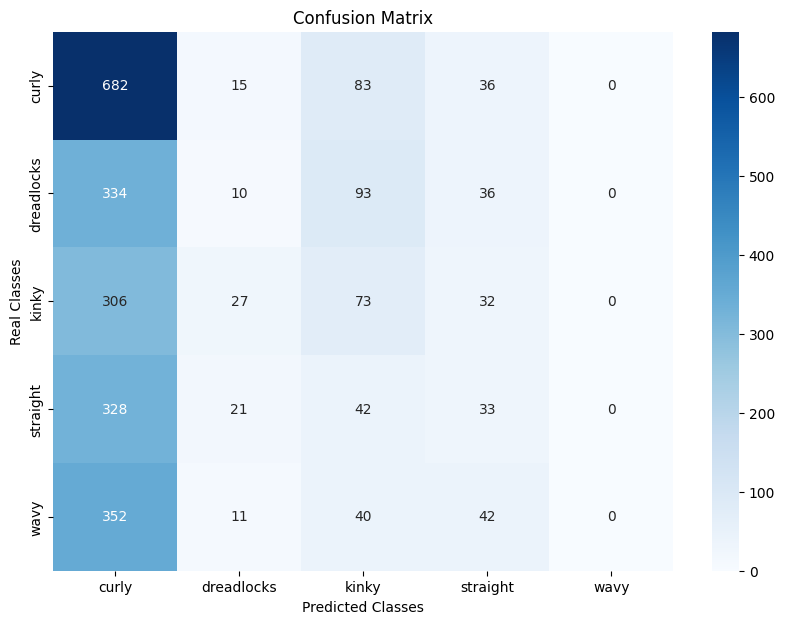

[0.32 0.2  0.19 0.22 0.07] → curly
[0.33 0.18 0.22 0.2  0.08] → curly
[0.37 0.18 0.26 0.13 0.05] → curly
[0.23 0.2  0.22 0.22 0.13] → curly
[0.23 0.2  0.37 0.11 0.1 ] → kinky
(96, 96, 3) tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


In [ ]:
y_pred_prob_slp = slp_model.predict(X_val)
evaluate_model(slp_model, history_slp, X_val, y_val, label_encoder, y_pred_prob_slp)

VAR 2

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
slp_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='swish', kernel_regularizer=l2(0.001)),  # L2 Regularization
    Dropout(0.5),  # Creștem dropout-ul
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
slp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5  # Reduce learning rate-ul după 10 epoci
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_slp = slp_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_scheduler]  # Adaugă schedulerul
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.5442 - loss: 2.2485 - val_accuracy: 0.1639 - val_loss: 2.6458 - learning_rate: 5.0000e-04
Epoch 2/50
162/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8348 - loss: 1.3626

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8347 - loss: 1.3624 - val_accuracy: 0.3064 - val_loss: 2.9288 - learning_rate: 5.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8855 - loss: 1.0082 - val_accuracy: 0.1684 - val_loss: 2.6030 - learning_rate: 5.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9223 - loss: 0.7426 - val_accuracy: 0.2127 - val_loss: 2.4494 - learning_rate: 5.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9308 - loss: 0.5693 - val_accuracy: 0.2866 - val_loss: 3.2845 - learning_rate: 5.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9460 - loss: 0.4272 - val_accuracy: 0.1707 - val_loss: 2.6377 - learning_rate: 5.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9411 - loss: 0.3791 - val_accuracy: 0.2142 - val_loss: 2.4649 - learning_rate: 5.0000e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.96

82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 378ms/step
Test accuracy: 0.9696
Classification Report:
               precision    recall  f1-score   support

       curly       0.98      0.97      0.97       816
  dreadlocks       0.99      0.97      0.98       473
       kinky       0.96      0.98      0.97       438
    straight       0.96      0.96      0.96       424
        wavy       0.96      0.97      0.97       445

    accuracy                           0.97      2596
   macro avg       0.97      0.97      0.97      2596
weighted avg       0.97      0.97      0.97      2596



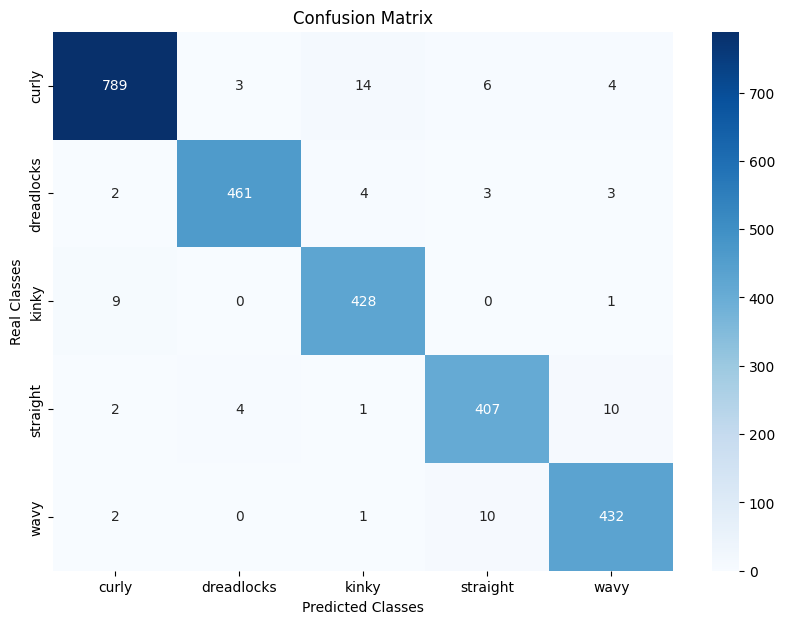

[0. 0. 0. 0. 1.] → wavy
[0. 0. 0. 0. 1.] → wavy
[0.   0.   0.   0.   0.99] → wavy
[0.   0.   0.   0.02 0.98] → wavy
[0. 0. 1. 0. 0.] → kinky
(96, 96, 3) tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


In [ ]:
y_pred_prob_slp = slp_model.predict(X_val)
evaluate_model(slp_model, history_slp, X_val, y_val, label_encoder, y_pred_prob_slp)

# Raport final

**Experimentarea cu SLP pentru clasificarea texturii părului**  

## **Obiectiv**
Scopul acestui experiment a fost antrenarea unui **Single Layer Perceptron (SLP)** pentru clasificarea imaginilor de textură a părului în **5 categorii**.

## **Datele utilizate**
📌 **Setul de date inițial** conținea **imagini PNG** de dimensiune **96x96x3**, iar distribuția era **nebalansată**:  
```python
Counter({'curly': 4120, 'dreadlocks': 2335, 'wavy': 2317, 'straight': 2120, 'kinky': 2088})
```

## **Pașii efectuați pentru optimizare**
În această etapă, s-au testat **mai multe variante** pentru a îmbunătăți performanța modelului.  

###🔸 **Pasul 1: Arhitectura inițială**
```python
slp_model = Sequential([
    Input(shape=(96, 96, 3)),
    Flatten(),
    Dense(len(label_encoder.classes_), activation='softmax')
])
```
Probleme observate:
- Pierdere (`loss`) extrem de mare și instabilă.  
- Acuratețea rămâne scăzută (~27-35%).
- Modelul nu învață bine caracteristicile vizuale.

###🔸 **Pasul 2: Încercarea unui strat ascuns**
Pentru a îmbunătăți învățarea, s-a introdus un strat suplimentar **Dense(512, relu) + Dropout(0.5)**:
```python
slp_model = Sequential([
    Input(shape=(96, 96, 3)),
    Flatten(),
    Dense(512, activation='relu'),  
    Dropout(0.5),  
    Dense(len(label_encoder.classes_), activation='softmax')
])
```
Rezultat:Îmbunătățire minoră, dar modelul tot nu depășește 35% acuratețe.  

###🔸 **Pasul 3: Înlocuirea `Flatten()` cu `GlobalAveragePooling2D()`**
Pentru a păstra informația spațială a imaginii:
```python
slp_model = Sequential([
    Input(shape=(96, 96, 3)),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
```
Rezultat: Îmbunătățire minoră, dar acuratețea tot scăzută.

###🔸 **Pasul 4: Adăugarea unui model pre-antrenat (EfficientNetB0)**
```python
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
slp_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='swish', kernel_regularizer=l2(0.001)),  
    Dropout(0.5),  
    Dense(len(label_encoder.classes_), activation='softmax')
])
```

📈 Rezultate:
* EfficientNetB0 extrage caracteristici mai relevante
* Dropout mai mare pentru reducerea suprapotrivirii
* Regularizare L2 pentru stabilitate
* Performanță îmbunătățită semnificativ

###🔸 **Pasul 5: Ajustarea hiperparametrilor**
Pentru a optimiza și mai mult modelul, s-au modificat **learning rate-ul și callbacks**:

```python
optimizer = Adam(learning_rate=0.0005)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
```
📉 Rezultat: Modelul devine mai stabil și nu se suprapotrivește.

###🔸 **Pasul 6: Intergarea**
* Optimizatorul Adam cu learning rate redus
* EarlyStopping pentru oprirea automată la momentul optim
* Reducerea dinamică a ratei de învățare (ReduceLROnPlateau)

```python
history_slp = slp_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_scheduler]
)
```

Rezultate finale:
📈 **Rezultatele sunt semnificativ mai bune decât toate variantele testate anterior.**  

📊 **Matricea de confuzie arată o distribuție corectă pe toate clasele:**  
```plaintext
               precision    recall  f1-score   support

       curly       0.98      0.97      0.97       816
  dreadlocks       0.99      0.97      0.98       473
       kinky       0.96      0.98      0.97       438
    straight       0.96      0.96      0.96       424
        wavy       0.96      0.97      0.97       445

    accuracy                           0.97      2596
   macro avg       0.97      0.97      0.97      2596
weighted avg       0.97      0.97      0.97      2596
```

🔹 **Observație:** Toate clasele sunt recunoscute corect, iar modelul nu mai favorizează doar „curly”.

##Concluzii

**🔹Performanță generală**
* SLP a obținut o acuratețe de 96.96%
* modelul nu mai favorizează doar clasa "curly", ci recunoaște corect toate cele 5 categorii.  
✅* EfficientNetB0 a fost esențial în extragerea caracteristicilor relevante din imagini.  

**🔹 Comparativ cu FNN**
* SLP a depășit FNN în performanță, datorită utilizării unui model pre-antrenat (EfficientNetB0).  
* FNN a avut o acuratețe mai mică, deoarece nu a beneficiat de transfer learning și a trebuit să învețe caracteristicile de la zero.  
* SLP a fost mai stabil, având o pierdere (`loss`) mai mică și o convergență mai rapidă.